In [14]:
import pickle
from models import *
from data_utils import *
import torch
import os 
from numpy.random import choice
from IPython.display import display, HTML
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
VALID = pickle.load(open('./data/valid_candidates.pkl', 'rb'))

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
class RecipeMindDemo(object):
    def __init__(self):
        print("Loading and Equipping the RecipeMind model....")
        ROOT_PATH = './saved/RecipeMind_CIKM2022_Final_0_recipemind_1005/'
        args = pickle.load(open(ROOT_PATH+'model_config.pkl', 'rb'))
        args.model_analysis = True
        self.model = load_recipe_model(args).cuda()
        chkpt = torch.load(ROOT_PATH+'epoch_best.mdl')
        self.model.load_state_dict(chkpt['model_state_dict'])
        self.model.eval() # the model

        print("Loading Collate Function for RecipeMind")
        self.collate = CollateFn(args)

        df = pd.read_csv('./data/recipemind_subset_2_scores.csv', index_col=0)
        all_ingreds  = list(self.collate.ingred2vec.keys())
        only_ingreds = df['input_elm'].unique().tolist()
        
        for k in all_ingreds:
            if '<J>/'+k not in only_ingreds:
                del self.collate.ingred2vec[k]
        self.collate.fn_inference([])
        print("Preparing all possible Ingredient Candidates....")
        self.idx2ingred = self.collate.idx2ingred # list of ingredients

        # print(self.model)
        
    def clear_attn_maps(self):
        self.model.ele_encoder.pmx[0].mab.multihead.attention.attention_maps = []
        self.model.ele_encoder.pmx[1].mab.multihead.attention.attention_maps = []
        self.model.ele_encoder.pmx[2].mab.multihead.attention.attention_maps = []
        self.model.ele_encoder.sab[0].mab.multihead.attention.attention_maps = []
        self.model.ele_encoder.sab[1].mab.multihead.attention.attention_maps = []
        self.model.ele_encoder.sab[2].mab.multihead.attention.attention_maps = []

    def __call__(self, ingredients, tags=[], topK=10, validonly=True):
        
        N = len(ingredients)
        N = min(6, N)
        # Tags will not work... the model sucks ass

        if isinstance(ingredients, list):
            jQ = ['<J>/' + i for i in ingredients]
        elif isinstance(ingredients, str):
            jQ = ['<J>/' + ingredients]
        else:
            print("The data structure is inadequate!", ingredients)
            jQ = []

        Q = jQ
        D = self.collate.fn_recipemind([RecipeMindData(0, {'xQ':jQ,'xA':'<J>/'+a,'yS':0.0}) for a in self.idx2ingred])
        D = self.model(D)
        pred_scores = numpify(D['xS'].detach()).reshape(-1)
        pred_ranked = (-pred_scores).argsort().tolist()
        pred_scores = [pred_scores[x] for x in pred_ranked]
        pred_ranked = [self.idx2ingred[x] for x in pred_ranked]
        top_recommendations = list(zip(pred_ranked, pred_scores))
        top_recommendations = [xy for xy in top_recommendations if xy[0] not in ingredients]
        if validonly:
            top_recommendations = [xy for xy in top_recommendations if '<J>/'+xy[0] in VALID[N+1].index]

        return top_recommendations[:topK]

def make_analysis_results(demo, ing_set, num_iter):
    ranking_results = []
    init_size = len(ing_set)
    attention_dfs = [np.zeros((num_iter, num_iter+len(ing_set))) for _ in range(3)]
    attention_maps = []
    for n in range(num_iter):
        demo.clear_attn_maps()
        ranking = demo(ing_set, validonly=False)
        ranking_results.append(ranking)
        top_idx = demo.idx2ingred.index(ranking[0][0])
        for i in range(3):
            a_list = []
            for h in range(8):
                a = demo.model.ele_encoder.pmx[i].mab.multihead.attention.attention_maps[0]
#                 print(attn.shape)
                a_list.append(a[2391*h:2391*(h+1),:,:])
            attn = np.stack(a_list, axis=1).mean(1)[:,0,:]
            attention_dfs[i][n,:attn.shape[1]] = attn[top_idx,:]
#             attention_maps.append((f'Iter: {n+1}, Tier: {i+1}', np.stack(attn_list, axis=1).mean(1)[:,0,:]))
        
        ing_set.append(ranking[0][0])
        
    df_columns = ing_set
    df_indices = ing_set[init_size:]
    
    output = []
    for x in attention_dfs:
        x = pd.DataFrame(x, columns=df_columns, index=df_indices)
        x[x==0] = np.nan
        r = x.rank(axis=1, na_option='keep', ascending=False, method='first')
        output.append((x,r))
        
    return output, ranking_results
    
def plot_heatmap_withrank(df, rf, fig_name):
    import matplotlib.pyplot as plt
    import seaborn as sns; sns.set_theme()

    fontsize_pt = plt.rcParams['ytick.labelsize']
    dpi = 72.27 / 5

    matrix_height_pt = fontsize_pt * df.shape[0]
    matrix_height_in = matrix_height_pt / dpi
    matrix_width_pt = fontsize_pt * df.shape[1]
    matrix_width_in = matrix_width_pt / dpi

    top_margin = 0.04  # in percentage of the figure height
    bottom_margin = 0.04 # in percentage of the figure height
    figure_height = matrix_height_in / (1 - top_margin - bottom_margin)
    figure_width  = matrix_width_in / (1 - top_margin - bottom_margin)

    fig, ax = plt.subplots(
            figsize=(figure_width,figure_height), 
            gridspec_kw=dict(top=1-top_margin, bottom=bottom_margin))

    # let seaborn do it's thing
    
    ax = sns.heatmap(rf, ax=ax,cmap="Reds_r", square=True, cbar=None, annot_kws={'va':'top'},    fmt=".3f", annot=df)
    for t in ax.texts: t.set_text("("+t.get_text()+")")
    ax = sns.heatmap(rf, ax=ax,cmap="Reds_r", square=True, cbar=None, annot_kws={'va':'bottom'}, fmt=".0f", annot=rf)
    fg= ax.get_figure()
    fg.savefig('./plots/'+fig_name+'.png', transparent=True, bbox_inches='tight')
    
    df.to_csv(fig_name+'_dataframe.csv')
    
    
def perform_ideation_scenario(model_instance, initial_ingredients):
    y, _ = make_analysis_results(model_instance, initial_ingredients, 8)
    plot_heatmap_withrank(y[2][0], y[2][1], '[&]'.join(initial_ingredients))
    
demo = RecipeMindDemo()

Loading and Equipping the RecipeMind model....
Loading Collate Function for RecipeMind
Preparing all possible Ingredient Candidates....


## RecipeMind Ideation Scenario 1 (carrots and onions)

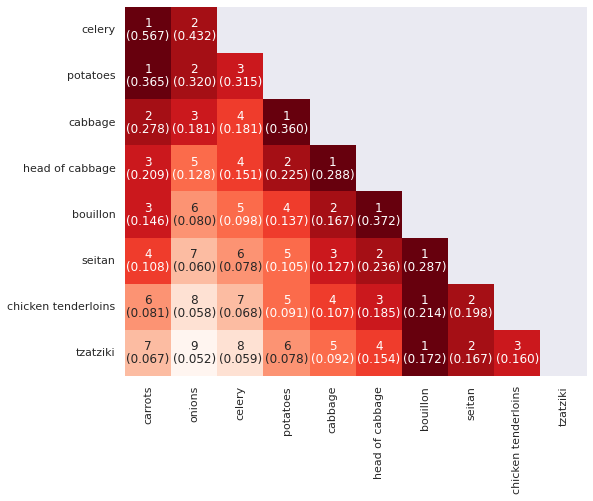

In [15]:
perform_ideation_scenario(demo, ['carrots', 'onions'])

## RecipeMind Ideation Scenario 2 (buttermilk and flour)

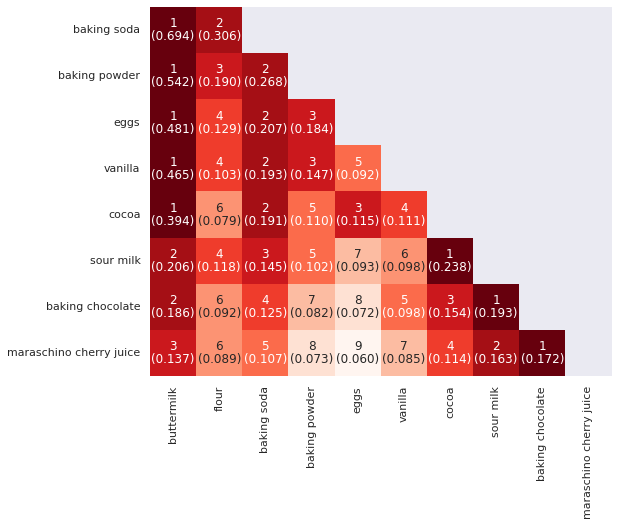

In [16]:
perform_ideation_scenario(demo, ['buttermilk', 'flour'])